### Import Modules

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import Counter
import numpy as np

### The graphs

#### The Data

In [22]:
hero_df = pd.read_csv('hero-network.csv')
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

#### Pre-processing

In [3]:
def preprocessing(df):
    
    # get rid of "/" at the end of the names
    df['hero1'] = df['hero1'].str.strip('/')
    df['hero2'] = df['hero2'].str.strip('/')
    
    # get rid of spaces at the end of the string
    df['hero1'] = df['hero1'].str.strip(' ')
    df['hero2'] = df['hero2'].str.strip(' ')
    
    # transform 'SPIDER-MAN/PETER PARKER' to 'SPIDER-MAN/PETER PAR' to match the name in edges.csv
    df['hero1'].replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', inplace=True)
    df['hero2'].replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', inplace=True)
    
    # Remove entries with same values in both columns in hero_df
    index_to_delete = df[df[['hero1','hero2']].nunique(axis=1) == 1].index
    df.drop(index_to_delete, axis=0, inplace=True)

    return df

In [4]:
hero_df = preprocessing(hero_df)
hero_df

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


#### Graphs

In [5]:
data = hero_df.copy()

In [6]:
# weigh G1 based on the number of collaborations

data = data.groupby(['hero1', 'hero2']).size().reset_index(name = 'count')
data['weight'] = 1/data['count'] # the inverse of the number of collaborations

In [7]:
G1 = nx.from_pandas_edgelist(data, 'hero1', 'hero2', edge_attr='weight')
G2 = nx.from_pandas_edgelist(edges_df, 'hero', 'comic')

### Functionality 1

Function **Functionality1** takes as inputs:
* the $Graph$ which, in our case, it's either $G1$ or $G2$
* $graphtype$ which takes values 1 or 2
* $nodes\_df$, the dataframe containing all the hero and comic nodes.
* $edges\_df$, the dataframe containing all the relationships between hero and comic nodes.
* and finally $N$, the number of top-N heroes we are considering in our analysis.

#### The Top_n heroes
**Top_n** is just a list of the $n$ heroes who have appeared in the most number of comics. We exploit the $value\_counts()$ function and we take the top $n$ heroes i.e., the ones having the highest degree or number of connections with the comic nodes and put those names ($.index$) in a list ($.tolist()$). As for $G1$ we are only interested in hero nodes, we just need to create a subgraph of $G1$ containing solely the heroes listed in $top\_n$. Instead, for $G2$ we are also interested in the comic nodes. Therefore, we need to recover the edge list from the $edges\_df$ which solely contains the connections between the $top\_n$ heroes and the comics they can be found in. Then, we build the sup graph using the $nx.from\_pandas\_edgelist()$ function from the newly defined edge list $edges\_df$.

#### 1.1 The number of nodes
For graph $G1$ we just need to use $Graph.nodes()$ function. For graph $G2$ it's slightly more complicated as we need to consider the $top\_n$ heroes as well as the comics that are linked to at least one of the $top\_n$ heroes. Once we identified those nodes in $nodes\_df$, we can group by node type and count ($.size()$) the number of hero nodes and comic nodes.

#### 1.2 The number of collaborations of each superhero with the others (only if type 1)
The number of collaborations is just the **degree** of each superhero ($Graph.degree()$). Functionality1 returns a dictionary having as keys the heroes and as values the degree or number of connections with the other superheroes in the graph.

#### 1.3 The number of heroes that have appeared in each comic (only if type 2)
Similarly as for $G1$, the number of heroes that have appeared in each comic is jus the degree of each comic. 

#### 1.4 The network's density
Found by using the $nx.density()$ function of $Networkx$.

#### 1.5 The network's degree distribution
The degree distribution is depicted in **Visualization1** through the use of an another function that creates the histogram.

#### 1.6 Average degree
The average degree is defined as the total sum of the degrees in the network over the number of nodes in the network.

#### 1.7 The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
First, we calculate the 95th percentile of the degree distribution by using $np.percentile()$. Then, we select only those nodes having degree greater than $perc$. Finally, we build a dataframe containing the **Network's Hubs** sorted in descending order according to their degree.

#### 1.8 Whether the Network is sparse or dense
$Density$ takes values between 0 and 1. The closer the density is to 1, the more dense the network is. I set the threshold to 50%. If the density is above 50% then, we consider the network *dense*, otherwise *sparse*.

In [23]:
def functionality1(Graph, graphtype, nodes_df, edges_df, N):
    
            
    top_n = edges_df['hero'].value_counts().iloc[:N].index.tolist() # list of top_n heroes
    edges_df = edges_df[edges_df.hero.isin(top_n)] # get only the edges (connections) where the hero is in the top_n
    
    if graphtype == 1:
        
        if N == len(Graph.nodes()):
            sub_Graph = Graph
        else:
            sub_Graph = Graph.subgraph(top_n)
        
        nodes = len(sub_Graph.nodes()) # number of nodes
        
        degree = dict(sub_Graph.degree()) # number of collaborations = degree (number of connections) of each superhero
        
        
    elif graphtype == 2:
        
        sub_Graph = nx.from_pandas_edgelist(edges_df, 'hero', 'comic') # build a graph starting from the newly defined edges_df
        
        # get only those nodes that either are in the top_n (heroes) or comic nodes that are connected to the top_n hero nodes
        nodes_df = nodes_df[(nodes_df.node.isin(top_n)) | (nodes_df.node.isin(edges_df[edges_df.hero.isin(top_n)].comic.unique().tolist()))]
        nodes = nodes_df.groupby('type').size() # number of nodes for each type (hero or comic)
        
        degree = dict(sub_Graph.degree(edges_df['comic']))
        
        
    # average degree
    avg_deg = round(sum(degree.values())/len(degree), 2)
    
    # 95th percentile
    perc = np.percentile(list(degree.values()), 95)
    hubs, hub_degree = [], []
    for node in degree:
        if degree[node] > perc:
            hubs.append(node)
            hub_degree.append(degree[node])
        
    # hubs dataframe sorted in descending order by degree
    hubs_df = pd.DataFrame({'hub':hubs,
                            'degree':hub_degree}).sort_values('degree', ascending = False).reset_index(drop=True)
    
    
    # network density
    density = round(nx.density(sub_Graph), 5)
    
    if density > 0.5: # maximum density is 1 for complete graphs
        is_dense = "dense"
    else:
        is_dense = "sparse"
        
        
    return nodes, density, degree, avg_deg, is_dense, hubs_df

### Visualization 1

#### 1.1 A table containing the following general information about the graph: Number of nodes in the network, Density of the network. Average degree of the network, Whether the network is sparse or dense

#### Example1: N = 40

* Let's let $N$ to 40. Therefore, we are considering the $top\_40$ hero nodes (listed in $edges\_df$).

In [14]:
nodes_G1, density_G1, degree_G1, avg_deg_G1, is_dense_G1, hubs_df_G1 = functionality1(G1, 1, nodes_df, edges_df, 40)
nodes_G2, density_G2, degree_G2, avg_deg_G2, is_dense_G2, hubs_df_G2 = functionality1(G2, 2, nodes_df, edges_df, 40)

* As can be seen in the table below, the number of hero nodes is equal to 39 even though we wanted the $top\_40$ heroes. This means that at least one of the nodes listed in $edges\_df$ is not in $nodes\_df$.
* The number of comic nodes is much larger than the number of hero nodes, this is way theh network's density is a lot smaller than for $G1$.

In [15]:
table_G1 = [['number of nodes', 'density', 'average degree', 'dense or sparse'], 
         [nodes_G1, density_G1, avg_deg_G1, is_dense_G1]]

print(tabulate(table_G1, tablefmt='grid'))

+-----------------+---------+----------------+-----------------+
| number of nodes | density | average degree | dense or sparse |
+-----------------+---------+----------------+-----------------+
| 40              | 0.98974 | 38.6           | dense           |
+-----------------+---------+----------------+-----------------+


In [16]:
table_G2 = [['number of comic nodes', 'number of hero nodes', 'density', 'average degree', 'dense or sparse'], 
            [nodes_G2[0], nodes_G2[1], density_G2, avg_deg_G2, is_dense_G2]]

print(tabulate(table_G2, tablefmt='grid'))

+-----------------------+----------------------+---------+----------------+-----------------+
| number of comic nodes | number of hero nodes | density | average degree | dense or sparse |
+-----------------------+----------------------+---------+----------------+-----------------+
| 8464                  | 39                   | 0.00068 | 2.92           | sparse          |
+-----------------------+----------------------+---------+----------------+-----------------+


#### Example 2: N = all nodes
* Now, let's consider the whole Graphs $G1$ and $G2$. We will stick with this example until the end of $Visualization2$.

In [24]:
nodes_G1, density_G1, degree_G1, avg_deg_G1, is_dense_G1, hubs_df_G1 = functionality1(G1, 1, nodes_df, edges_df, len(G1.nodes()))
nodes_G2, density_G2, degree_G2, avg_deg_G2, is_dense_G2, hubs_df_G2 = functionality1(G2, 2, nodes_df, edges_df, len(G2.nodes()))

* Now, both graphs are sparse with less that $1$% density.

In [25]:
table_G1 = [['number of nodes', 'density', 'average degree', 'dense or sparse'], 
         [nodes_G1, density_G1, avg_deg_G1, is_dense_G1]]

print(tabulate(table_G1, tablefmt='grid'))

+-----------------+---------+----------------+-----------------+
| number of nodes | density | average degree | dense or sparse |
+-----------------+---------+----------------+-----------------+
| 6421            | 0.00811 | 52.05          | sparse          |
+-----------------+---------+----------------+-----------------+


In [26]:
table_G2 = [['number of comic nodes', 'number of hero nodes', 'density', 'average degree', 'dense or sparse'], 
            [nodes_G2[0], nodes_G2[1], density_G2, avg_deg_G2, is_dense_G2]]

print(tabulate(table_G2, tablefmt='grid'))

+-----------------------+----------------------+---------+----------------+-----------------+
| number of comic nodes | number of hero nodes | density | average degree | dense or sparse |
+-----------------------+----------------------+---------+----------------+-----------------+
| 12651                 | 6438                 | 0.00053 | 7.6            | sparse          |
+-----------------------+----------------------+---------+----------------+-----------------+


#### 1.2 A table that lists the network's hubs

* There are $320$ hubs in $G1$, as the 95th percentile of the degree distribution is equal to $190$.
* The three most important hubs are Captain America, Spiderman and Iron man.

In [27]:
hubs_df_G1

,hub,degree
0,CAPTAIN AMERICA,1903
1,SPIDER-MAN/PETER PARKER,1737
2,IRON MAN/TONY STARK,1521
3,THING/BENJAMIN J. GR,1416
4,MR. FANTASTIC/REED R,1377
...,...,...
315,VULTURE/ADRIAN TOOME,193
316,AJAK/TECUMOTZIN [ETE,192
317,HOBGOBLIN V/JASON PH,191
318,FIREFIST/RUSTY COLLI,191


* There are $553$ hubs in $G2$, as the 95th percentile of the degree distribution is equal to $19$.

In [28]:
hubs_df_G2

,hub,degree
0,COC 1,111
1,IW 3,91
2,IW 1,90
3,H2 279,87
4,IW 4,80
...,...,...
548,A 187,20
549,UX 384,20
550,A 168,20
551,A 100,20


#### 1.3 A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

#### Barchart function

* We exploit the $degree\_dict$ found in $functionality1$ to build a **barchart** depicting the degree of the first 50 heroes ($.head(50)$) in descending order.

In [29]:
def barchart(degree_dict, color, node_type):
    
    nodes, degree = [], []
    for node in degree_dict:
        nodes.append(node)
        degree.append(degree_dict[node])

    # hubs dataframe sorted in descending order by degree
    deg_df = pd.DataFrame({'node':nodes,
                           'degree':degree}).sort_values('degree', ascending = False).reset_index(drop=True).head(50)

    fig = plt.figure(figsize = (20, 10))
 
    # creating the bar plot
    plt.bar(deg_df.node, deg_df.degree, color = color,
            width = 0.6)
    plt.xticks(rotation='vertical')
    plt.xlabel(str(node_type), size = 15)
    plt.ylabel("No. of collaborations", size = 15)
    plt.title("No. of collaborations of each " + str(node_type), size = 20)
    
    return plt.show()

* Obviously the plot below represents the **first 50 hubs** seen in *point 1.2*.

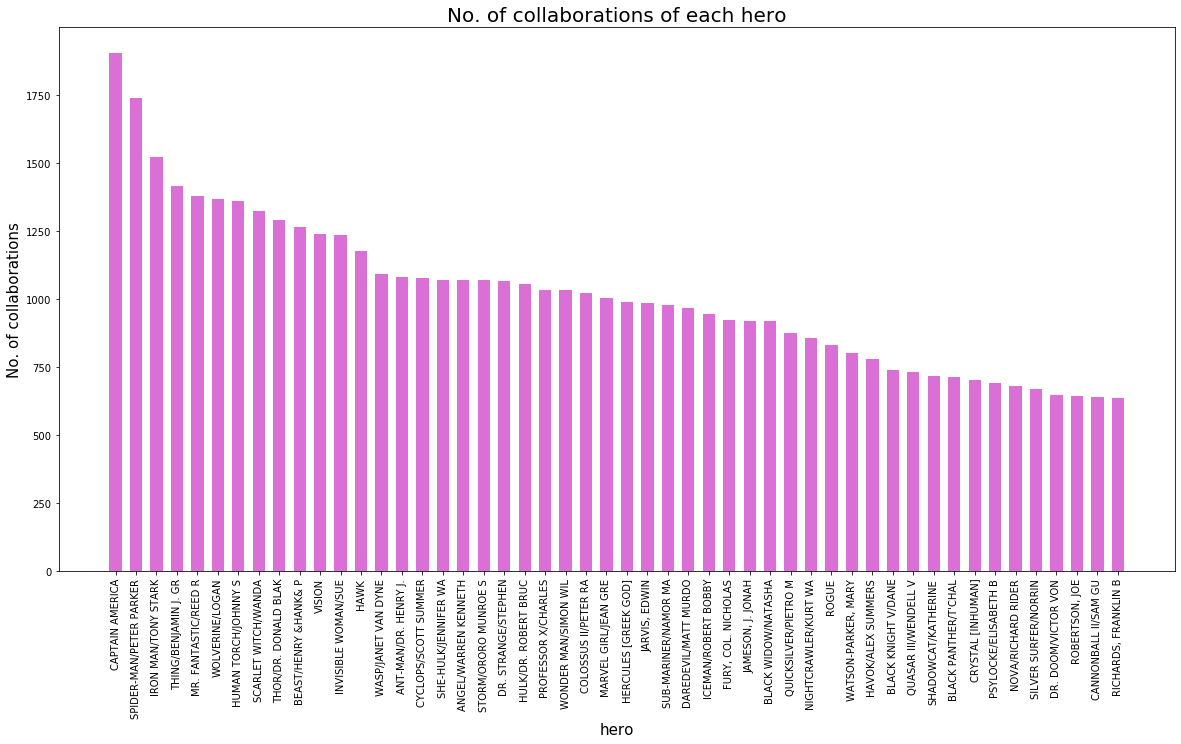

In [30]:
barchart(degree_G1, "orchid", "hero")

#### 1.4 A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

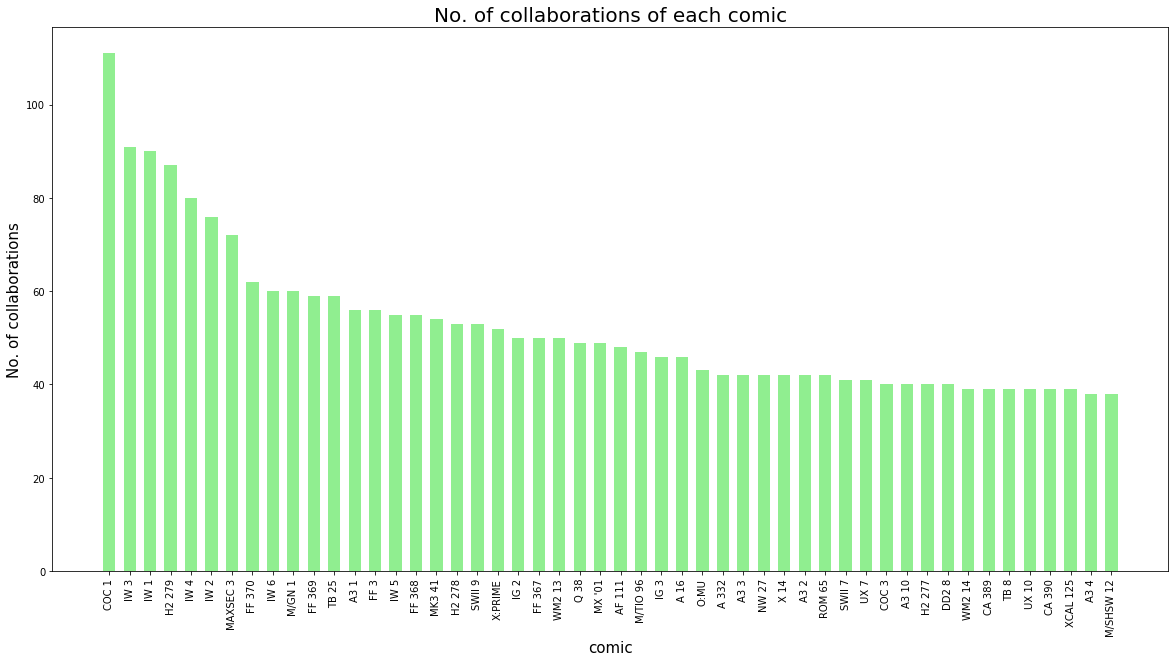

In [31]:
barchart(degree_G2, "lightgreen", "comic")

#### 1.5 A plot depicting the degree distribution of the network

#### The function

* We exploit the $degree\_dict$ found in $functionality1$ to build a **histogram** depicting the network's degree distribution.

In [32]:
def degree_distribution(degree_dict, color):
    
    degree_sequence = sorted([degree_dict[k] for k in degree_dict if degree_dict[k] < 200], reverse=True)  # degree sequence

    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    
    fig = plt.figure(figsize = (20, 10))
    plt.bar(deg, cnt, width=0.80, color=color)

    plt.title("Degree Histogram", size = 20)
    plt.ylabel("Count", size = 15)
    plt.xlabel("Degree", size = 15)

    return plt.show()

#### The plots

* Both distribution are really skewed, as the plots are heavily shifted to the left. This means that the majority of nodes in both networks have smaller degrees while only a few **"more popular" heroes or comics** have a much higher degree than the rest, equivalently those are the **hubs**.

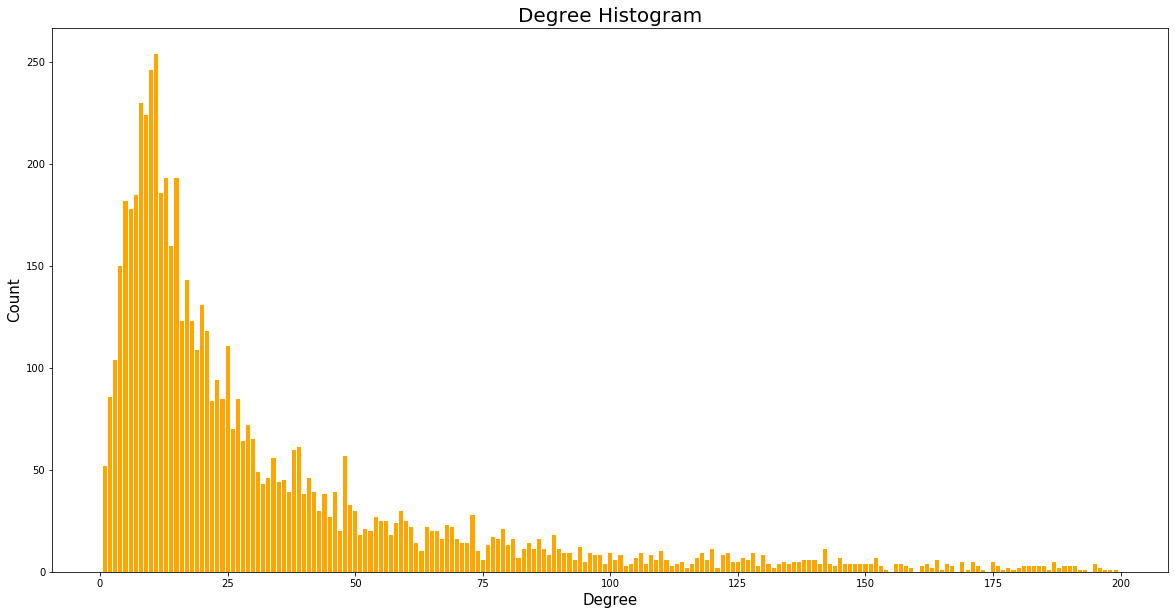

In [33]:
degree_distribution(degree_G1, 'orange')

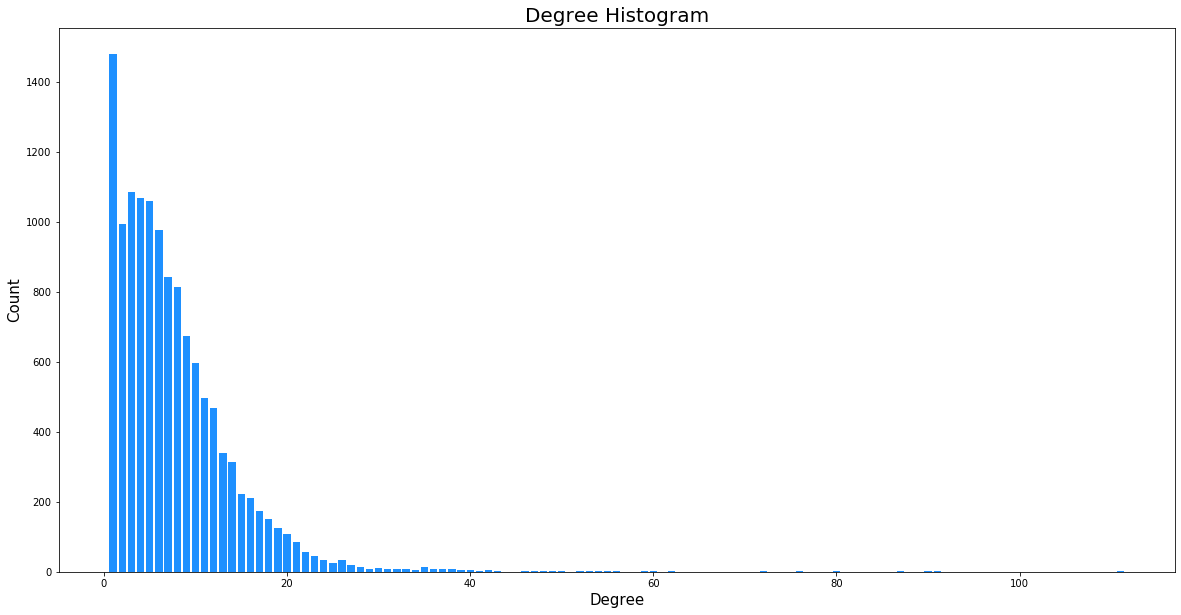

In [34]:
degree_distribution(degree_G2, 'dodgerblue')